# Project Image recognition (with ResNets)

The goal is to train a neural network for visual recognition (i.e., given an image, predict its class label). Below is the original article explaining the details so called residual networks (ResNets), i.e., current state-of-the-art architecture for this type of problem. The task is to implement a ResNet and feel free to adjust things where you see fit. *Do not just copy the PyTorch example. Try to assess which parts of the architecture are more relevant than others recognition performance.

Resources: MNIST and CIFAR-10/100 data available via PyTorch

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

We download our data set the MNIST:

In [8]:
trainSet = torchvision.datasets.MNIST(
    root='./data/MNIST', 
    train=True, 
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((.1307,),(.3081))
    ]), 
)

trainLoader = torch.utils.data.DataLoader(
    trainSet, batch_size = 64
)


Lets have a look at our data:

In [3]:
import numpy as np
import matplotlib.pyplot as plt

torch.set_printoptions(linewidth=120)

In [10]:
len(trainSet)

60000

In [11]:
trainSet.train_labels

tensor([5, 0, 4,  ..., 5, 6, 8])

In [12]:
trainSet.train_labels.bincount()

tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])

In [13]:
sample = next(iter(trainSet))
len(sample)


2

In [14]:
type(sample)

tuple

In [15]:
image, label = sample

In [16]:
image.shape

torch.Size([1, 28, 28])

In [17]:
label.shape

torch.Size([])

label: tensor(5)


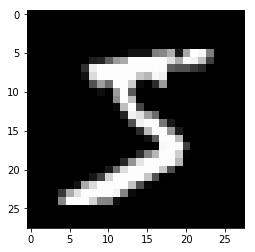

In [18]:
plt.imshow(image.squeeze(), cmap='gray')
print('label:', label)

In [19]:
batch = next(iter(trainLoader))
len(batch)

2

In [20]:
type(batch)

list

In [21]:
images, labels = batch
images.shape

torch.Size([10, 1, 28, 28])

labels: tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])


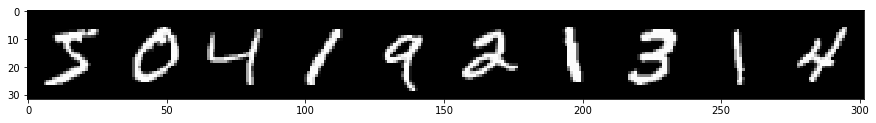

In [22]:
grid = torchvision.utils.make_grid(images, nrow = 10)

plt.figure(figsize=(15, 15))
plt.imshow(np.transpose(grid, (1,2,0)))

print('labels:', labels)

# ResNet implemenation

In [23]:
from torch import nn

In [26]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes,
                     out_planes,
                     kernel_size = 1,
                     stride = stride,
                     bias=False)

In [27]:
# First test:
l = conv3x3(10,20,stride=1)
print(l(torch.randn(4,10,32,32)).size())

torch.Size([4, 20, 32, 32])


We create a class that implements the residual block:

In [37]:
class BasicBlock_v1(nn.Module):
    expansion = 1
    
    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock_v1, self).__init__()
        
        """
        3x3 convolution inplanes -> outplanes 
        (spatial size maintianed), BN + ReLU
        """
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.stride = stride
        self.downsample = downsample
        
        """
        3x3 convolution inplanes -> outplanes
        (spatial size maintained) + BN
        """
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        
    def forward(self, x):
        residual = x # save x
        
        # conv -> bn -> relu
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # conv -> bn
        out = self.conv2(out)
        out = self.bn2(out)
        
        # x + F(x) - this realizes the shortcut conn.
        out += residual
        out = self.relu(out) # final relu
        
        return out

In [38]:
# test input data, batch size 4, 32 channels, spatial dim 12x12.
x = torch.randn(4, 64, 12, 12)

# Push this data through basic block
bb = BasicBlock_v1(64,64)
print(bb(x).size())

torch.Size([4, 64, 12, 12])


In [67]:
class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock_v2, self).__init__()
        
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.stride = stride
        self.downsample = downsample
        
    def forward(self, x):
        residual = x # save x
        
        # conv -> bn -> relu
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            residual = self.downsample(x)
        
        # x + F(x) - this realizes the shortcut conn.
        out += residual
        out = self.relu(out) # final relu
        
        return out

In [68]:
down_fn = conv1x1(64,64,stride=2)

x = torch.randn(4, 64, 12,12)

bb = BasicBlock_v2(64,64,stride=2, downsample=down_fn)

print(bb(x).size())

torch.Size([4, 64, 6, 6])


# Bottleneck block

In [36]:
class Bottleneck(nn.Module):
    """
    The expansion factor controls the number of output
    channels of the last 1x1 convolution layer.
    """
    expansion = 4
    
    def __init__(self, inplanes, planes, stride = 1, downsample=None):
        super(Bottleneck, self).__init__()
        
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        residual = x
    
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.downsample is not None:
            residual = self.downsample(x)
            
        out += residual
        out = self.relu(out)
        
        return out
        

In [39]:
down_fn = conv1x1(256,256,stride=2)
x = torch.randn(4,256,12,12)
bb = Bottleneck(256,64,stride=2, downsample=down_fn)
print(bb(x).size())

torch.Size([4, 256, 6, 6])


# Actual ResNet implementation:

In [61]:
#from torchvision.models import resnet18

class ResNet(nn.Module):
    
    def __init__(self, block, layers, num_classes=10):
        self.inplanes = 10
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 7, stride = 2, padding = 3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(10)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 10, layers[0])
        self.layer2 = self._make_layer(block, 20, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 40, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 80, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(80 * block.expansion, num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

<function Tensor.type>

In [62]:
def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model

In [71]:
simp_model = resnet18()

params_to_update = []
for name,param in simp_model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)



TypeError: super(type, obj): obj must be an instance or subtype of type

In [70]:
device = 'cpu'

params_to_update = []
opt = torch.optim.SGD(params_to_update, lr = .001, momentum = .9)
criterion = nn.CrossEntropyLoss()


simp_model.to(device)
simp_model.train()

n_epochs = 10

for i in range(n_epochs):
    e_loss = 0
    
    for x, y in data_loader:
        
        x = x.to(device)
        y = y.to(device)
        
        simp_model.zero_grad()
        out = simp_model(x)
        loss = criterion(out, y)
        e_loss += loss.item()
        loss.backward()
        opt.step()
        
    print('Epoch {}: {:.4f}'.format(i, e_loss))

ValueError: optimizer got an empty parameter list

# A simple CNN for MNIST:
Link: https://www.youtube.com/watch?v=8gZR4Q3262k

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torch.autograd import Variable

kwargs = {}
train_data = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                    transform=transforms.Compose([transforms.ToTensor(),
                    transforms.Normalize((.1307,),(.3081,))])),
batch_size=64, shuffle=True, **kwargs)
    
test_data = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, 
                    transform=transforms.Compose([transforms.ToTensor(),
                    transforms.Normalize((.1307,),(.3081,))])),
batch_size=64, shuffle=True, **kwargs)

In [2]:
class Netz(nn.Module):
    def __init__(self):
        super(Netz, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv_dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 60)
        self.fc2 = nn.Linear(60, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv_dropout(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)
        
    
model = Netz()
#model.cuda()



    

In [3]:
optimizer = optim.SGD(model.parameters(), lr=.1, momentum=.8)

def train(epoch):
    model.train()
    for batch_id, (data, target) in enumerate(train_data):
        #data = data.cuda()
        #target = target.cuda()
        data = Variable(data)
        target = Variable(target)
        optimizer.zero_grad()
        out = model(data)
        criterion = F.nll_loss
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_id * len(data), len(train_data.dataset),
                100. * batch_id / len(train_data), loss.item()))


for epoch in range(1, 5):
    train(epoch) 
    


C:\Users\laptop\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 [0/60000 (0%)]	Loss: 2.320946
Epoch: 1 [64/60000 (0%)]	Loss: 2.315864
Epoch: 1 [128/60000 (0%)]	Loss: 2.303274
Epoch: 1 [192/60000 (0%)]	Loss: 2.261895
Epoch: 1 [256/60000 (0%)]	Loss: 2.290977
Epoch: 1 [320/60000 (1%)]	Loss: 2.274229
Epoch: 1 [384/60000 (1%)]	Loss: 2.213404
Epoch: 1 [448/60000 (1%)]	Loss: 2.221548
Epoch: 1 [512/60000 (1%)]	Loss: 2.174332
Epoch: 1 [576/60000 (1%)]	Loss: 2.097306
Epoch: 1 [640/60000 (1%)]	Loss: 1.910321
Epoch: 1 [704/60000 (1%)]	Loss: 1.846426
Epoch: 1 [768/60000 (1%)]	Loss: 1.806900
Epoch: 1 [832/60000 (1%)]	Loss: 2.132623
Epoch: 1 [896/60000 (1%)]	Loss: 1.601528
Epoch: 1 [960/60000 (2%)]	Loss: 1.796144
Epoch: 1 [1024/60000 (2%)]	Loss: 1.884572
Epoch: 1 [1088/60000 (2%)]	Loss: 1.504917
Epoch: 1 [1152/60000 (2%)]	Loss: 1.250685
Epoch: 1 [1216/60000 (2%)]	Loss: 1.338503
Epoch: 1 [1280/60000 (2%)]	Loss: 1.419640
Epoch: 1 [1344/60000 (2%)]	Loss: 1.220727
Epoch: 1 [1408/60000 (2%)]	Loss: 1.089352
Epoch: 1 [1472/60000 (2%)]	Loss: 0.987379
Epoch: 1 [1

Epoch: 1 [12288/60000 (20%)]	Loss: 0.358696
Epoch: 1 [12352/60000 (21%)]	Loss: 0.122193
Epoch: 1 [12416/60000 (21%)]	Loss: 0.267661
Epoch: 1 [12480/60000 (21%)]	Loss: 0.743386
Epoch: 1 [12544/60000 (21%)]	Loss: 0.484595
Epoch: 1 [12608/60000 (21%)]	Loss: 0.243359
Epoch: 1 [12672/60000 (21%)]	Loss: 0.422337
Epoch: 1 [12736/60000 (21%)]	Loss: 0.440296
Epoch: 1 [12800/60000 (21%)]	Loss: 0.464487
Epoch: 1 [12864/60000 (21%)]	Loss: 0.511177
Epoch: 1 [12928/60000 (22%)]	Loss: 0.365175
Epoch: 1 [12992/60000 (22%)]	Loss: 0.459159
Epoch: 1 [13056/60000 (22%)]	Loss: 0.465231
Epoch: 1 [13120/60000 (22%)]	Loss: 0.376116
Epoch: 1 [13184/60000 (22%)]	Loss: 0.193569
Epoch: 1 [13248/60000 (22%)]	Loss: 0.644911
Epoch: 1 [13312/60000 (22%)]	Loss: 0.533022
Epoch: 1 [13376/60000 (22%)]	Loss: 0.529094
Epoch: 1 [13440/60000 (22%)]	Loss: 0.438619
Epoch: 1 [13504/60000 (22%)]	Loss: 0.591369
Epoch: 1 [13568/60000 (23%)]	Loss: 0.451162
Epoch: 1 [13632/60000 (23%)]	Loss: 0.304319
Epoch: 1 [13696/60000 (23%)]	Los

Epoch: 1 [24192/60000 (40%)]	Loss: 0.259439
Epoch: 1 [24256/60000 (40%)]	Loss: 0.313424
Epoch: 1 [24320/60000 (41%)]	Loss: 0.273674
Epoch: 1 [24384/60000 (41%)]	Loss: 0.137117
Epoch: 1 [24448/60000 (41%)]	Loss: 0.132100
Epoch: 1 [24512/60000 (41%)]	Loss: 0.861497
Epoch: 1 [24576/60000 (41%)]	Loss: 0.238299
Epoch: 1 [24640/60000 (41%)]	Loss: 0.396576
Epoch: 1 [24704/60000 (41%)]	Loss: 0.326235
Epoch: 1 [24768/60000 (41%)]	Loss: 0.286641
Epoch: 1 [24832/60000 (41%)]	Loss: 0.207039
Epoch: 1 [24896/60000 (41%)]	Loss: 0.170464
Epoch: 1 [24960/60000 (42%)]	Loss: 0.285266
Epoch: 1 [25024/60000 (42%)]	Loss: 0.128146
Epoch: 1 [25088/60000 (42%)]	Loss: 0.501469
Epoch: 1 [25152/60000 (42%)]	Loss: 0.241309
Epoch: 1 [25216/60000 (42%)]	Loss: 0.231613
Epoch: 1 [25280/60000 (42%)]	Loss: 0.114268
Epoch: 1 [25344/60000 (42%)]	Loss: 0.248960
Epoch: 1 [25408/60000 (42%)]	Loss: 0.295722
Epoch: 1 [25472/60000 (42%)]	Loss: 0.307999
Epoch: 1 [25536/60000 (43%)]	Loss: 0.248366
Epoch: 1 [25600/60000 (43%)]	Los

Epoch: 1 [36096/60000 (60%)]	Loss: 0.053614
Epoch: 1 [36160/60000 (60%)]	Loss: 0.345776
Epoch: 1 [36224/60000 (60%)]	Loss: 0.625720
Epoch: 1 [36288/60000 (60%)]	Loss: 0.362938
Epoch: 1 [36352/60000 (61%)]	Loss: 0.234717
Epoch: 1 [36416/60000 (61%)]	Loss: 0.162281
Epoch: 1 [36480/60000 (61%)]	Loss: 0.234384
Epoch: 1 [36544/60000 (61%)]	Loss: 0.217960
Epoch: 1 [36608/60000 (61%)]	Loss: 0.204487
Epoch: 1 [36672/60000 (61%)]	Loss: 0.196681
Epoch: 1 [36736/60000 (61%)]	Loss: 0.272450
Epoch: 1 [36800/60000 (61%)]	Loss: 0.156689
Epoch: 1 [36864/60000 (61%)]	Loss: 0.409658
Epoch: 1 [36928/60000 (62%)]	Loss: 0.238770
Epoch: 1 [36992/60000 (62%)]	Loss: 0.204540
Epoch: 1 [37056/60000 (62%)]	Loss: 0.163409
Epoch: 1 [37120/60000 (62%)]	Loss: 0.178520
Epoch: 1 [37184/60000 (62%)]	Loss: 0.425718
Epoch: 1 [37248/60000 (62%)]	Loss: 0.656904
Epoch: 1 [37312/60000 (62%)]	Loss: 0.207495
Epoch: 1 [37376/60000 (62%)]	Loss: 0.281097
Epoch: 1 [37440/60000 (62%)]	Loss: 0.260909
Epoch: 1 [37504/60000 (62%)]	Los

Epoch: 1 [48000/60000 (80%)]	Loss: 0.514709
Epoch: 1 [48064/60000 (80%)]	Loss: 0.324295
Epoch: 1 [48128/60000 (80%)]	Loss: 0.264323
Epoch: 1 [48192/60000 (80%)]	Loss: 0.255613
Epoch: 1 [48256/60000 (80%)]	Loss: 0.120483
Epoch: 1 [48320/60000 (80%)]	Loss: 0.157853
Epoch: 1 [48384/60000 (81%)]	Loss: 0.181409
Epoch: 1 [48448/60000 (81%)]	Loss: 0.247134
Epoch: 1 [48512/60000 (81%)]	Loss: 0.064954
Epoch: 1 [48576/60000 (81%)]	Loss: 0.196919
Epoch: 1 [48640/60000 (81%)]	Loss: 0.190769
Epoch: 1 [48704/60000 (81%)]	Loss: 0.135326
Epoch: 1 [48768/60000 (81%)]	Loss: 0.032213
Epoch: 1 [48832/60000 (81%)]	Loss: 0.083144
Epoch: 1 [48896/60000 (81%)]	Loss: 0.418888
Epoch: 1 [48960/60000 (82%)]	Loss: 0.111061
Epoch: 1 [49024/60000 (82%)]	Loss: 0.205680
Epoch: 1 [49088/60000 (82%)]	Loss: 0.056535
Epoch: 1 [49152/60000 (82%)]	Loss: 0.296160
Epoch: 1 [49216/60000 (82%)]	Loss: 0.059228
Epoch: 1 [49280/60000 (82%)]	Loss: 0.633315
Epoch: 1 [49344/60000 (82%)]	Loss: 0.173769
Epoch: 1 [49408/60000 (82%)]	Los

Epoch: 1 [59904/60000 (100%)]	Loss: 0.134737
Epoch: 1 [29984/60000 (100%)]	Loss: 0.054513
Epoch: 2 [0/60000 (0%)]	Loss: 0.328914
Epoch: 2 [64/60000 (0%)]	Loss: 0.238126
Epoch: 2 [128/60000 (0%)]	Loss: 0.111896
Epoch: 2 [192/60000 (0%)]	Loss: 0.061750
Epoch: 2 [256/60000 (0%)]	Loss: 0.242999
Epoch: 2 [320/60000 (1%)]	Loss: 0.167397
Epoch: 2 [384/60000 (1%)]	Loss: 0.457541
Epoch: 2 [448/60000 (1%)]	Loss: 0.049907
Epoch: 2 [512/60000 (1%)]	Loss: 0.247425
Epoch: 2 [576/60000 (1%)]	Loss: 0.051791
Epoch: 2 [640/60000 (1%)]	Loss: 0.049013
Epoch: 2 [704/60000 (1%)]	Loss: 0.231552
Epoch: 2 [768/60000 (1%)]	Loss: 0.161862
Epoch: 2 [832/60000 (1%)]	Loss: 0.315292
Epoch: 2 [896/60000 (1%)]	Loss: 0.351646
Epoch: 2 [960/60000 (2%)]	Loss: 0.486339
Epoch: 2 [1024/60000 (2%)]	Loss: 0.224704
Epoch: 2 [1088/60000 (2%)]	Loss: 0.228268
Epoch: 2 [1152/60000 (2%)]	Loss: 0.152751
Epoch: 2 [1216/60000 (2%)]	Loss: 0.394401
Epoch: 2 [1280/60000 (2%)]	Loss: 0.240076
Epoch: 2 [1344/60000 (2%)]	Loss: 0.286723
Epoch

Epoch: 2 [12160/60000 (20%)]	Loss: 0.110891
Epoch: 2 [12224/60000 (20%)]	Loss: 0.610439
Epoch: 2 [12288/60000 (20%)]	Loss: 0.179929
Epoch: 2 [12352/60000 (21%)]	Loss: 0.140677
Epoch: 2 [12416/60000 (21%)]	Loss: 0.116420
Epoch: 2 [12480/60000 (21%)]	Loss: 0.207757
Epoch: 2 [12544/60000 (21%)]	Loss: 0.110107
Epoch: 2 [12608/60000 (21%)]	Loss: 0.223028
Epoch: 2 [12672/60000 (21%)]	Loss: 0.242990
Epoch: 2 [12736/60000 (21%)]	Loss: 0.510341
Epoch: 2 [12800/60000 (21%)]	Loss: 0.490606
Epoch: 2 [12864/60000 (21%)]	Loss: 0.133539
Epoch: 2 [12928/60000 (22%)]	Loss: 0.141429
Epoch: 2 [12992/60000 (22%)]	Loss: 0.158598
Epoch: 2 [13056/60000 (22%)]	Loss: 0.368839
Epoch: 2 [13120/60000 (22%)]	Loss: 0.255785
Epoch: 2 [13184/60000 (22%)]	Loss: 0.095339
Epoch: 2 [13248/60000 (22%)]	Loss: 0.307491
Epoch: 2 [13312/60000 (22%)]	Loss: 0.176737
Epoch: 2 [13376/60000 (22%)]	Loss: 0.481364
Epoch: 2 [13440/60000 (22%)]	Loss: 0.121597
Epoch: 2 [13504/60000 (22%)]	Loss: 0.213714
Epoch: 2 [13568/60000 (23%)]	Los

Epoch: 2 [24064/60000 (40%)]	Loss: 0.230411
Epoch: 2 [24128/60000 (40%)]	Loss: 0.265268
Epoch: 2 [24192/60000 (40%)]	Loss: 0.178035
Epoch: 2 [24256/60000 (40%)]	Loss: 0.167927
Epoch: 2 [24320/60000 (41%)]	Loss: 0.089843
Epoch: 2 [24384/60000 (41%)]	Loss: 0.247847
Epoch: 2 [24448/60000 (41%)]	Loss: 0.101164
Epoch: 2 [24512/60000 (41%)]	Loss: 0.154482
Epoch: 2 [24576/60000 (41%)]	Loss: 0.098272
Epoch: 2 [24640/60000 (41%)]	Loss: 0.323470
Epoch: 2 [24704/60000 (41%)]	Loss: 0.324697
Epoch: 2 [24768/60000 (41%)]	Loss: 0.175412
Epoch: 2 [24832/60000 (41%)]	Loss: 0.399827
Epoch: 2 [24896/60000 (41%)]	Loss: 0.352252
Epoch: 2 [24960/60000 (42%)]	Loss: 0.477808
Epoch: 2 [25024/60000 (42%)]	Loss: 0.241864
Epoch: 2 [25088/60000 (42%)]	Loss: 0.181637
Epoch: 2 [25152/60000 (42%)]	Loss: 0.204133
Epoch: 2 [25216/60000 (42%)]	Loss: 0.172183
Epoch: 2 [25280/60000 (42%)]	Loss: 0.098219
Epoch: 2 [25344/60000 (42%)]	Loss: 0.156780
Epoch: 2 [25408/60000 (42%)]	Loss: 0.221426
Epoch: 2 [25472/60000 (42%)]	Los

Epoch: 2 [35968/60000 (60%)]	Loss: 0.218686
Epoch: 2 [36032/60000 (60%)]	Loss: 0.046454
Epoch: 2 [36096/60000 (60%)]	Loss: 0.142983
Epoch: 2 [36160/60000 (60%)]	Loss: 0.153108
Epoch: 2 [36224/60000 (60%)]	Loss: 0.208967
Epoch: 2 [36288/60000 (60%)]	Loss: 0.348283
Epoch: 2 [36352/60000 (61%)]	Loss: 0.185874
Epoch: 2 [36416/60000 (61%)]	Loss: 0.238095
Epoch: 2 [36480/60000 (61%)]	Loss: 0.272148
Epoch: 2 [36544/60000 (61%)]	Loss: 0.351598
Epoch: 2 [36608/60000 (61%)]	Loss: 0.217095
Epoch: 2 [36672/60000 (61%)]	Loss: 0.240887
Epoch: 2 [36736/60000 (61%)]	Loss: 0.228638
Epoch: 2 [36800/60000 (61%)]	Loss: 0.038174
Epoch: 2 [36864/60000 (61%)]	Loss: 0.206874
Epoch: 2 [36928/60000 (62%)]	Loss: 0.078420
Epoch: 2 [36992/60000 (62%)]	Loss: 0.342552
Epoch: 2 [37056/60000 (62%)]	Loss: 0.249002
Epoch: 2 [37120/60000 (62%)]	Loss: 0.232072
Epoch: 2 [37184/60000 (62%)]	Loss: 0.301296
Epoch: 2 [37248/60000 (62%)]	Loss: 0.213658
Epoch: 2 [37312/60000 (62%)]	Loss: 0.134945
Epoch: 2 [37376/60000 (62%)]	Los

Epoch: 2 [47872/60000 (80%)]	Loss: 0.160428
Epoch: 2 [47936/60000 (80%)]	Loss: 0.068599
Epoch: 2 [48000/60000 (80%)]	Loss: 0.203149
Epoch: 2 [48064/60000 (80%)]	Loss: 0.152741
Epoch: 2 [48128/60000 (80%)]	Loss: 0.044577
Epoch: 2 [48192/60000 (80%)]	Loss: 0.138578
Epoch: 2 [48256/60000 (80%)]	Loss: 0.412978
Epoch: 2 [48320/60000 (80%)]	Loss: 0.112223
Epoch: 2 [48384/60000 (81%)]	Loss: 0.130377
Epoch: 2 [48448/60000 (81%)]	Loss: 0.048191
Epoch: 2 [48512/60000 (81%)]	Loss: 0.425494
Epoch: 2 [48576/60000 (81%)]	Loss: 0.117862
Epoch: 2 [48640/60000 (81%)]	Loss: 0.119212
Epoch: 2 [48704/60000 (81%)]	Loss: 0.099353
Epoch: 2 [48768/60000 (81%)]	Loss: 0.280614
Epoch: 2 [48832/60000 (81%)]	Loss: 0.117024
Epoch: 2 [48896/60000 (81%)]	Loss: 0.258988
Epoch: 2 [48960/60000 (82%)]	Loss: 0.055836
Epoch: 2 [49024/60000 (82%)]	Loss: 0.144829
Epoch: 2 [49088/60000 (82%)]	Loss: 0.610943
Epoch: 2 [49152/60000 (82%)]	Loss: 0.189072
Epoch: 2 [49216/60000 (82%)]	Loss: 0.326325
Epoch: 2 [49280/60000 (82%)]	Los

Epoch: 2 [59776/60000 (100%)]	Loss: 0.515446
Epoch: 2 [59840/60000 (100%)]	Loss: 0.139902
Epoch: 2 [59904/60000 (100%)]	Loss: 0.256665
Epoch: 2 [29984/60000 (100%)]	Loss: 0.016486
Epoch: 3 [0/60000 (0%)]	Loss: 0.072748
Epoch: 3 [64/60000 (0%)]	Loss: 0.528175
Epoch: 3 [128/60000 (0%)]	Loss: 0.079711
Epoch: 3 [192/60000 (0%)]	Loss: 0.428220
Epoch: 3 [256/60000 (0%)]	Loss: 0.098444
Epoch: 3 [320/60000 (1%)]	Loss: 0.333203
Epoch: 3 [384/60000 (1%)]	Loss: 0.102842
Epoch: 3 [448/60000 (1%)]	Loss: 0.257997
Epoch: 3 [512/60000 (1%)]	Loss: 0.181417
Epoch: 3 [576/60000 (1%)]	Loss: 0.117673
Epoch: 3 [640/60000 (1%)]	Loss: 0.672411
Epoch: 3 [704/60000 (1%)]	Loss: 0.430632
Epoch: 3 [768/60000 (1%)]	Loss: 0.444914
Epoch: 3 [832/60000 (1%)]	Loss: 0.076930
Epoch: 3 [896/60000 (1%)]	Loss: 0.103084
Epoch: 3 [960/60000 (2%)]	Loss: 0.202463
Epoch: 3 [1024/60000 (2%)]	Loss: 0.311789
Epoch: 3 [1088/60000 (2%)]	Loss: 0.147637
Epoch: 3 [1152/60000 (2%)]	Loss: 0.118037
Epoch: 3 [1216/60000 (2%)]	Loss: 0.273217

Epoch: 3 [12032/60000 (20%)]	Loss: 0.221762
Epoch: 3 [12096/60000 (20%)]	Loss: 0.490380
Epoch: 3 [12160/60000 (20%)]	Loss: 0.394415
Epoch: 3 [12224/60000 (20%)]	Loss: 0.397337
Epoch: 3 [12288/60000 (20%)]	Loss: 0.096200
Epoch: 3 [12352/60000 (21%)]	Loss: 0.190552
Epoch: 3 [12416/60000 (21%)]	Loss: 0.172012
Epoch: 3 [12480/60000 (21%)]	Loss: 0.106536
Epoch: 3 [12544/60000 (21%)]	Loss: 0.175562
Epoch: 3 [12608/60000 (21%)]	Loss: 0.181868
Epoch: 3 [12672/60000 (21%)]	Loss: 0.172327
Epoch: 3 [12736/60000 (21%)]	Loss: 0.143604
Epoch: 3 [12800/60000 (21%)]	Loss: 0.064790
Epoch: 3 [12864/60000 (21%)]	Loss: 0.097105
Epoch: 3 [12928/60000 (22%)]	Loss: 0.159164
Epoch: 3 [12992/60000 (22%)]	Loss: 0.202226
Epoch: 3 [13056/60000 (22%)]	Loss: 0.052403
Epoch: 3 [13120/60000 (22%)]	Loss: 0.071104
Epoch: 3 [13184/60000 (22%)]	Loss: 0.440095
Epoch: 3 [13248/60000 (22%)]	Loss: 0.259911
Epoch: 3 [13312/60000 (22%)]	Loss: 0.057210
Epoch: 3 [13376/60000 (22%)]	Loss: 0.127338
Epoch: 3 [13440/60000 (22%)]	Los

Epoch: 3 [23936/60000 (40%)]	Loss: 0.023588
Epoch: 3 [24000/60000 (40%)]	Loss: 0.398096
Epoch: 3 [24064/60000 (40%)]	Loss: 0.269355
Epoch: 3 [24128/60000 (40%)]	Loss: 0.079412
Epoch: 3 [24192/60000 (40%)]	Loss: 0.325298
Epoch: 3 [24256/60000 (40%)]	Loss: 0.027066
Epoch: 3 [24320/60000 (41%)]	Loss: 0.238235
Epoch: 3 [24384/60000 (41%)]	Loss: 0.037653
Epoch: 3 [24448/60000 (41%)]	Loss: 0.117971
Epoch: 3 [24512/60000 (41%)]	Loss: 0.529620
Epoch: 3 [24576/60000 (41%)]	Loss: 0.203935
Epoch: 3 [24640/60000 (41%)]	Loss: 0.319966
Epoch: 3 [24704/60000 (41%)]	Loss: 0.122924
Epoch: 3 [24768/60000 (41%)]	Loss: 0.526289
Epoch: 3 [24832/60000 (41%)]	Loss: 0.244843
Epoch: 3 [24896/60000 (41%)]	Loss: 0.140602
Epoch: 3 [24960/60000 (42%)]	Loss: 0.129132
Epoch: 3 [25024/60000 (42%)]	Loss: 0.196579
Epoch: 3 [25088/60000 (42%)]	Loss: 0.101881
Epoch: 3 [25152/60000 (42%)]	Loss: 0.183798
Epoch: 3 [25216/60000 (42%)]	Loss: 0.235885
Epoch: 3 [25280/60000 (42%)]	Loss: 0.095175
Epoch: 3 [25344/60000 (42%)]	Los

Epoch: 3 [35840/60000 (60%)]	Loss: 0.364713
Epoch: 3 [35904/60000 (60%)]	Loss: 0.133326
Epoch: 3 [35968/60000 (60%)]	Loss: 0.067326
Epoch: 3 [36032/60000 (60%)]	Loss: 0.410524
Epoch: 3 [36096/60000 (60%)]	Loss: 0.308317
Epoch: 3 [36160/60000 (60%)]	Loss: 0.139478
Epoch: 3 [36224/60000 (60%)]	Loss: 0.162653
Epoch: 3 [36288/60000 (60%)]	Loss: 0.215274
Epoch: 3 [36352/60000 (61%)]	Loss: 0.066545
Epoch: 3 [36416/60000 (61%)]	Loss: 0.121965
Epoch: 3 [36480/60000 (61%)]	Loss: 0.152543
Epoch: 3 [36544/60000 (61%)]	Loss: 0.686377
Epoch: 3 [36608/60000 (61%)]	Loss: 0.306535
Epoch: 3 [36672/60000 (61%)]	Loss: 0.072683
Epoch: 3 [36736/60000 (61%)]	Loss: 0.088490
Epoch: 3 [36800/60000 (61%)]	Loss: 0.215654
Epoch: 3 [36864/60000 (61%)]	Loss: 0.275303
Epoch: 3 [36928/60000 (62%)]	Loss: 0.069062
Epoch: 3 [36992/60000 (62%)]	Loss: 0.241847
Epoch: 3 [37056/60000 (62%)]	Loss: 0.056450
Epoch: 3 [37120/60000 (62%)]	Loss: 0.070741
Epoch: 3 [37184/60000 (62%)]	Loss: 0.185047
Epoch: 3 [37248/60000 (62%)]	Los

Epoch: 3 [47744/60000 (80%)]	Loss: 0.310133
Epoch: 3 [47808/60000 (80%)]	Loss: 0.274169
Epoch: 3 [47872/60000 (80%)]	Loss: 0.055627
Epoch: 3 [47936/60000 (80%)]	Loss: 0.173320
Epoch: 3 [48000/60000 (80%)]	Loss: 0.220309
Epoch: 3 [48064/60000 (80%)]	Loss: 0.073692
Epoch: 3 [48128/60000 (80%)]	Loss: 0.116897
Epoch: 3 [48192/60000 (80%)]	Loss: 0.123037
Epoch: 3 [48256/60000 (80%)]	Loss: 0.301961
Epoch: 3 [48320/60000 (80%)]	Loss: 0.164021
Epoch: 3 [48384/60000 (81%)]	Loss: 0.198790
Epoch: 3 [48448/60000 (81%)]	Loss: 0.152429
Epoch: 3 [48512/60000 (81%)]	Loss: 0.179269
Epoch: 3 [48576/60000 (81%)]	Loss: 0.170856
Epoch: 3 [48640/60000 (81%)]	Loss: 0.094117
Epoch: 3 [48704/60000 (81%)]	Loss: 0.070548
Epoch: 3 [48768/60000 (81%)]	Loss: 0.161452
Epoch: 3 [48832/60000 (81%)]	Loss: 0.116163
Epoch: 3 [48896/60000 (81%)]	Loss: 0.075232
Epoch: 3 [48960/60000 (82%)]	Loss: 0.241066
Epoch: 3 [49024/60000 (82%)]	Loss: 0.130850
Epoch: 3 [49088/60000 (82%)]	Loss: 0.202687
Epoch: 3 [49152/60000 (82%)]	Los

Epoch: 3 [59648/60000 (99%)]	Loss: 0.243685
Epoch: 3 [59712/60000 (99%)]	Loss: 0.117873
Epoch: 3 [59776/60000 (100%)]	Loss: 0.190444
Epoch: 3 [59840/60000 (100%)]	Loss: 0.313442
Epoch: 3 [59904/60000 (100%)]	Loss: 0.083965
Epoch: 3 [29984/60000 (100%)]	Loss: 0.288123
Epoch: 4 [0/60000 (0%)]	Loss: 0.155859
Epoch: 4 [64/60000 (0%)]	Loss: 0.142335
Epoch: 4 [128/60000 (0%)]	Loss: 0.266360
Epoch: 4 [192/60000 (0%)]	Loss: 0.194098
Epoch: 4 [256/60000 (0%)]	Loss: 0.385528
Epoch: 4 [320/60000 (1%)]	Loss: 0.036726
Epoch: 4 [384/60000 (1%)]	Loss: 0.184653
Epoch: 4 [448/60000 (1%)]	Loss: 0.069556
Epoch: 4 [512/60000 (1%)]	Loss: 0.094843
Epoch: 4 [576/60000 (1%)]	Loss: 0.373998
Epoch: 4 [640/60000 (1%)]	Loss: 0.111368
Epoch: 4 [704/60000 (1%)]	Loss: 0.119623
Epoch: 4 [768/60000 (1%)]	Loss: 0.123322
Epoch: 4 [832/60000 (1%)]	Loss: 0.197292
Epoch: 4 [896/60000 (1%)]	Loss: 0.280471
Epoch: 4 [960/60000 (2%)]	Loss: 0.096470
Epoch: 4 [1024/60000 (2%)]	Loss: 0.081805
Epoch: 4 [1088/60000 (2%)]	Loss: 0.14

Epoch: 4 [11904/60000 (20%)]	Loss: 0.100906
Epoch: 4 [11968/60000 (20%)]	Loss: 0.090532
Epoch: 4 [12032/60000 (20%)]	Loss: 0.182866
Epoch: 4 [12096/60000 (20%)]	Loss: 0.388921
Epoch: 4 [12160/60000 (20%)]	Loss: 0.186540
Epoch: 4 [12224/60000 (20%)]	Loss: 0.030882
Epoch: 4 [12288/60000 (20%)]	Loss: 0.094625
Epoch: 4 [12352/60000 (21%)]	Loss: 0.211383
Epoch: 4 [12416/60000 (21%)]	Loss: 0.162252
Epoch: 4 [12480/60000 (21%)]	Loss: 0.166402
Epoch: 4 [12544/60000 (21%)]	Loss: 0.285149
Epoch: 4 [12608/60000 (21%)]	Loss: 0.234049
Epoch: 4 [12672/60000 (21%)]	Loss: 0.206281
Epoch: 4 [12736/60000 (21%)]	Loss: 0.115055
Epoch: 4 [12800/60000 (21%)]	Loss: 0.055652
Epoch: 4 [12864/60000 (21%)]	Loss: 0.171829
Epoch: 4 [12928/60000 (22%)]	Loss: 0.337286
Epoch: 4 [12992/60000 (22%)]	Loss: 0.025500
Epoch: 4 [13056/60000 (22%)]	Loss: 0.180382
Epoch: 4 [13120/60000 (22%)]	Loss: 0.264394
Epoch: 4 [13184/60000 (22%)]	Loss: 0.221831
Epoch: 4 [13248/60000 (22%)]	Loss: 0.073158
Epoch: 4 [13312/60000 (22%)]	Los

Epoch: 4 [23808/60000 (40%)]	Loss: 0.039367
Epoch: 4 [23872/60000 (40%)]	Loss: 0.212851
Epoch: 4 [23936/60000 (40%)]	Loss: 0.155110
Epoch: 4 [24000/60000 (40%)]	Loss: 0.168570
Epoch: 4 [24064/60000 (40%)]	Loss: 0.109317
Epoch: 4 [24128/60000 (40%)]	Loss: 0.093074
Epoch: 4 [24192/60000 (40%)]	Loss: 0.091920
Epoch: 4 [24256/60000 (40%)]	Loss: 0.194727
Epoch: 4 [24320/60000 (41%)]	Loss: 0.062964
Epoch: 4 [24384/60000 (41%)]	Loss: 0.076787
Epoch: 4 [24448/60000 (41%)]	Loss: 0.083869
Epoch: 4 [24512/60000 (41%)]	Loss: 0.156642
Epoch: 4 [24576/60000 (41%)]	Loss: 0.323289
Epoch: 4 [24640/60000 (41%)]	Loss: 0.044067
Epoch: 4 [24704/60000 (41%)]	Loss: 0.147392
Epoch: 4 [24768/60000 (41%)]	Loss: 0.192213
Epoch: 4 [24832/60000 (41%)]	Loss: 0.145639
Epoch: 4 [24896/60000 (41%)]	Loss: 0.234654
Epoch: 4 [24960/60000 (42%)]	Loss: 0.207455
Epoch: 4 [25024/60000 (42%)]	Loss: 0.162545
Epoch: 4 [25088/60000 (42%)]	Loss: 0.114508
Epoch: 4 [25152/60000 (42%)]	Loss: 0.151572
Epoch: 4 [25216/60000 (42%)]	Los

Epoch: 4 [35712/60000 (59%)]	Loss: 0.359661
Epoch: 4 [35776/60000 (60%)]	Loss: 0.289988
Epoch: 4 [35840/60000 (60%)]	Loss: 0.103714
Epoch: 4 [35904/60000 (60%)]	Loss: 0.135864
Epoch: 4 [35968/60000 (60%)]	Loss: 0.218398
Epoch: 4 [36032/60000 (60%)]	Loss: 0.259046
Epoch: 4 [36096/60000 (60%)]	Loss: 0.326944
Epoch: 4 [36160/60000 (60%)]	Loss: 0.106022
Epoch: 4 [36224/60000 (60%)]	Loss: 0.218339
Epoch: 4 [36288/60000 (60%)]	Loss: 0.168192
Epoch: 4 [36352/60000 (61%)]	Loss: 0.284432
Epoch: 4 [36416/60000 (61%)]	Loss: 0.027741
Epoch: 4 [36480/60000 (61%)]	Loss: 0.066505
Epoch: 4 [36544/60000 (61%)]	Loss: 0.162772
Epoch: 4 [36608/60000 (61%)]	Loss: 0.071822
Epoch: 4 [36672/60000 (61%)]	Loss: 0.222430
Epoch: 4 [36736/60000 (61%)]	Loss: 0.029494
Epoch: 4 [36800/60000 (61%)]	Loss: 0.162133
Epoch: 4 [36864/60000 (61%)]	Loss: 0.301045
Epoch: 4 [36928/60000 (62%)]	Loss: 0.144700
Epoch: 4 [36992/60000 (62%)]	Loss: 0.061960
Epoch: 4 [37056/60000 (62%)]	Loss: 0.165901
Epoch: 4 [37120/60000 (62%)]	Los

Epoch: 4 [47616/60000 (79%)]	Loss: 0.130557
Epoch: 4 [47680/60000 (79%)]	Loss: 0.134755
Epoch: 4 [47744/60000 (80%)]	Loss: 0.039255
Epoch: 4 [47808/60000 (80%)]	Loss: 0.221978
Epoch: 4 [47872/60000 (80%)]	Loss: 0.229030
Epoch: 4 [47936/60000 (80%)]	Loss: 0.138504
Epoch: 4 [48000/60000 (80%)]	Loss: 0.128412
Epoch: 4 [48064/60000 (80%)]	Loss: 0.252199
Epoch: 4 [48128/60000 (80%)]	Loss: 0.115795
Epoch: 4 [48192/60000 (80%)]	Loss: 0.180947
Epoch: 4 [48256/60000 (80%)]	Loss: 0.126698
Epoch: 4 [48320/60000 (80%)]	Loss: 0.301476
Epoch: 4 [48384/60000 (81%)]	Loss: 0.215153
Epoch: 4 [48448/60000 (81%)]	Loss: 0.213821
Epoch: 4 [48512/60000 (81%)]	Loss: 0.085633
Epoch: 4 [48576/60000 (81%)]	Loss: 0.160358
Epoch: 4 [48640/60000 (81%)]	Loss: 0.083578
Epoch: 4 [48704/60000 (81%)]	Loss: 0.035739
Epoch: 4 [48768/60000 (81%)]	Loss: 0.022113
Epoch: 4 [48832/60000 (81%)]	Loss: 0.024011
Epoch: 4 [48896/60000 (81%)]	Loss: 0.385312
Epoch: 4 [48960/60000 (82%)]	Loss: 0.190863
Epoch: 4 [49024/60000 (82%)]	Los

Epoch: 4 [59520/60000 (99%)]	Loss: 0.118859
Epoch: 4 [59584/60000 (99%)]	Loss: 0.385720
Epoch: 4 [59648/60000 (99%)]	Loss: 0.096875
Epoch: 4 [59712/60000 (99%)]	Loss: 0.041111
Epoch: 4 [59776/60000 (100%)]	Loss: 0.081067
Epoch: 4 [59840/60000 (100%)]	Loss: 0.102792
Epoch: 4 [59904/60000 (100%)]	Loss: 0.030080
Epoch: 4 [29984/60000 (100%)]	Loss: 0.251001


In [5]:
    def test():
        model.eval()
        loss = 0
        correct = 0
        for data, target in test_data:
            #data = Variable(data.cuda(), volatile=True)
            #target = Variable(target.cuda())
            out = model(data)
            loss += F.nll_loss(out, target, size_average=False).item()
            prediction = out.data.max(1, keepdim=True)[1]
            correct += prediction.eq(target.data.view_as(prediction)).cpu().sum()
        loss = loss / len(test_data.dataset)
        
        print('Test Loss: ', loss)
        print('Test Accuracy: ', 100.*correct.item()/len(test_data.dataset))       
   
    test()



C:\Users\laptop\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\laptop\Anaconda3\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test Loss:  0.09569116525650025
Test Accuracy:  97.26
